In [1]:
#Neural network training with syntethic in vivo dopamine and serotonin signals. 
import tensorflow as tf
import os
import keras
import pandas as pd
from tensorflow.keras import datasets, layers, models, utils, regularizers
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
from sklearn.model_selection import train_test_split
print(tf.__version__)
from sklearn.decomposition import PCA
from tensorflow.keras.layers import Activation, Dense, LeakyReLU
from sklearn.model_selection import KFold
import keras_tuner as kt
from tensorflow.keras.utils import plot_model

2.7.0


In [2]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer


def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))

In [3]:
#Load colorplot datasets. 
X = np.load('data.npz')['a'].reshape(5179, 200, 100, 1)

#Creating the labels. 
y = pd.read_excel('Labels_v1.xlsx', header = None).values

#Shuffling the dataset.
shuffler = np.random.permutation(len(y))
X = X[shuffler]
y = y[shuffler]
class_weights = generate_class_weights(y[:,0])

In [4]:
#Define a function to plot the loss per epoch 
def plot_loss(history):
    plt.figure()
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    plt.figure()
    plt.plot(history.history['accuracy'], label="acc")
    plt.plot(history.history['val_accuracy'], label="val.acc")
    plt.xlabel('Epoch')
    plt.ylabel('Acc.')
    
    #Define the model again with the optimal params.
    
def build_and_compile_model(): 
    model = models.Sequential()
    model.add(layers.LayerNormalization(axis = [1, 2, 3], input_shape=(200, 100, 1)))
    model.add(layers.Conv2D(100, (3, 3), activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l=0.01)))
    model.add(layers.MaxPooling2D((3, 3)))
    model.add(layers.Conv2D(10, (3, 3), activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l=0.01)))
    model.add(layers.MaxPooling2D((3, 3)))
    model.add(layers.Conv2D(10, (3, 3), activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l=0.01)))
    model.add(layers.Flatten())
    model.add(layers.Dense(1000, activation='relu'))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(1))
    model.summary()
    model.compile(loss=[tf.keras.losses.BinaryCrossentropy(from_logits=True)], optimizer=tf.keras.optimizers.Adam(0.0001), metrics=['accuracy'])
    
    plot_model(model, to_file='network_structure_baseline.png', show_shapes=True)

    return model

2022-02-27 22:51:59.190201: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-27 22:51:59.190325: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_normalization (LayerN  (None, 200, 100, 1)      40000     
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 198, 98, 100)      1000      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 66, 32, 100)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 30, 10)        9010      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 10, 10)       0         
 2D)                                                             
                      

2022-02-27 22:51:59.677734: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/25


2022-02-27 22:51:59.973957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 2.6042 - accuracy: 0.8320

2022-02-27 22:52:08.502039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - 9s 89ms/step - loss: 2.6042 - accuracy: 0.8320 - val_loss: 2.6491 - val_accuracy: 0.8649
Epoch 2/25
98/98 [==============================] - 8s 85ms/step - loss: 2.4304 - accuracy: 0.8989 - val_loss: 2.4693 - val_accuracy: 0.8977
Epoch 3/25
98/98 [==============================] - 8s 85ms/step - loss: 2.3266 - accuracy: 0.9047 - val_loss: 2.3624 - val_accuracy: 0.9044
Epoch 4/25
98/98 [==============================] - 8s 85ms/step - loss: 2.2182 - accuracy: 0.9276 - val_loss: 2.3569 - val_accuracy: 0.8909
Epoch 5/25
98/98 [==============================] - 8s 85ms/step - loss: 2.1220 - accuracy: 0.9495 - val_loss: 2.2251 - val_accuracy: 0.9035
Epoch 6/25
98/98 [==============================] - 8s 86ms/step - loss: 2.0304 - accuracy: 0.9633 - val_loss: 2.1697 - val_accuracy: 0.9131
Epoch 7/25
98/98 [==============================] - 8s 85ms/step - loss: 1.9543 - accuracy: 0.9704 - val_loss: 2.1474 - val_accuracy: 0.9025
Epoch 8/25
98/98 [======

2022-02-27 22:55:30.084039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_normalization_1 (Laye  (None, 200, 100, 1)      40000     
 rNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 198, 98, 100)      1000      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 66, 32, 100)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 30, 10)        9010      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 21, 10, 10)       0         
 2D)                                                             
                                                      

2022-02-27 22:55:31.027697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 2.6596 - accuracy: 0.8513

2022-02-27 22:55:39.658344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - 9s 91ms/step - loss: 2.6596 - accuracy: 0.8513 - val_loss: 2.6008 - val_accuracy: 0.8919
Epoch 2/25
98/98 [==============================] - 8s 86ms/step - loss: 2.5001 - accuracy: 0.9025 - val_loss: 2.5812 - val_accuracy: 0.8929
Epoch 3/25
98/98 [==============================] - 9s 89ms/step - loss: 2.3790 - accuracy: 0.9298 - val_loss: 2.4546 - val_accuracy: 0.8996
Epoch 4/25
98/98 [==============================] - 8s 85ms/step - loss: 2.2875 - accuracy: 0.9475 - val_loss: 2.4347 - val_accuracy: 0.8967
Epoch 5/25
98/98 [==============================] - 8s 85ms/step - loss: 2.1938 - accuracy: 0.9601 - val_loss: 2.3408 - val_accuracy: 0.9054
Epoch 6/25
98/98 [==============================] - 8s 85ms/step - loss: 2.1232 - accuracy: 0.9656 - val_loss: 2.3056 - val_accuracy: 0.9025
Epoch 7/25
98/98 [==============================] - 8s 85ms/step - loss: 2.0381 - accuracy: 0.9820 - val_loss: 2.2829 - val_accuracy: 0.9006
Epoch 8/25
98/98 [======

2022-02-27 22:59:00.349250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_normalization_2 (Laye  (None, 200, 100, 1)      40000     
 rNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 198, 98, 100)      1000      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 66, 32, 100)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 30, 10)        9010      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 21, 10, 10)       0         
 2D)                                                             
                                                      

2022-02-27 22:59:01.353641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 2.5544 - accuracy: 0.8677

2022-02-27 22:59:10.130908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - 9s 92ms/step - loss: 2.5544 - accuracy: 0.8677 - val_loss: 2.5112 - val_accuracy: 0.9044
Epoch 2/25
98/98 [==============================] - 9s 89ms/step - loss: 2.3919 - accuracy: 0.9047 - val_loss: 2.4399 - val_accuracy: 0.9006
Epoch 3/25
98/98 [==============================] - 9s 87ms/step - loss: 2.2884 - accuracy: 0.9076 - val_loss: 2.5585 - val_accuracy: 0.8320
Epoch 4/25
98/98 [==============================] - 8s 86ms/step - loss: 2.1912 - accuracy: 0.9276 - val_loss: 2.3028 - val_accuracy: 0.8909
Epoch 5/25
98/98 [==============================] - 9s 90ms/step - loss: 2.1136 - accuracy: 0.9434 - val_loss: 2.2085 - val_accuracy: 0.9083
Epoch 6/25
98/98 [==============================] - 8s 85ms/step - loss: 2.0370 - accuracy: 0.9491 - val_loss: 2.1470 - val_accuracy: 0.9131
Epoch 7/25
98/98 [==============================] - 8s 85ms/step - loss: 1.9607 - accuracy: 0.9704 - val_loss: 2.1844 - val_accuracy: 0.8880
Epoch 8/25
98/98 [======

2022-02-27 23:02:34.114622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_normalization_3 (Laye  (None, 200, 100, 1)      40000     
 rNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 198, 98, 100)      1000      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 66, 32, 100)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 30, 10)        9010      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 21, 10, 10)       0         
 2D)                                                             
                                                      

2022-02-27 23:02:35.141766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 2.6762 - accuracy: 0.8651

2022-02-27 23:02:43.476892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - 9s 88ms/step - loss: 2.6762 - accuracy: 0.8651 - val_loss: 2.5757 - val_accuracy: 0.9170
Epoch 2/25
98/98 [==============================] - 8s 85ms/step - loss: 2.5098 - accuracy: 0.8983 - val_loss: 2.5389 - val_accuracy: 0.9054
Epoch 3/25
98/98 [==============================] - 8s 86ms/step - loss: 2.3951 - accuracy: 0.9170 - val_loss: 2.4492 - val_accuracy: 0.9122
Epoch 4/25
98/98 [==============================] - 8s 85ms/step - loss: 2.2982 - accuracy: 0.9295 - val_loss: 2.4060 - val_accuracy: 0.9006
Epoch 5/25
98/98 [==============================] - 8s 86ms/step - loss: 2.1974 - accuracy: 0.9501 - val_loss: 2.2961 - val_accuracy: 0.9141
Epoch 6/25
98/98 [==============================] - 8s 86ms/step - loss: 2.1195 - accuracy: 0.9604 - val_loss: 2.2708 - val_accuracy: 0.9006
Epoch 7/25
98/98 [==============================] - 9s 87ms/step - loss: 2.0378 - accuracy: 0.9685 - val_loss: 2.1699 - val_accuracy: 0.9237
Epoch 8/25
98/98 [======

2022-02-27 23:06:06.040621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_normalization_4 (Laye  (None, 200, 100, 1)      40000     
 rNormalization)                                                 
                                                                 
 conv2d_12 (Conv2D)          (None, 198, 98, 100)      1000      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 66, 32, 100)      0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 30, 10)        9010      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 21, 10, 10)       0         
 2D)                                                             
                                                      

2022-02-27 23:06:07.038816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 2.6523 - accuracy: 0.8571

2022-02-27 23:06:15.816830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - 9s 92ms/step - loss: 2.6523 - accuracy: 0.8571 - val_loss: 2.6073 - val_accuracy: 0.8842
Epoch 2/25
98/98 [==============================] - 8s 85ms/step - loss: 2.4871 - accuracy: 0.8993 - val_loss: 2.7102 - val_accuracy: 0.8427
Epoch 3/25
98/98 [==============================] - 8s 84ms/step - loss: 2.3799 - accuracy: 0.9176 - val_loss: 2.5101 - val_accuracy: 0.8871
Epoch 4/25
98/98 [==============================] - 9s 87ms/step - loss: 2.2848 - accuracy: 0.9337 - val_loss: 2.3621 - val_accuracy: 0.9064
Epoch 5/25
98/98 [==============================] - 8s 85ms/step - loss: 2.1802 - accuracy: 0.9595 - val_loss: 2.3348 - val_accuracy: 0.8996
Epoch 6/25
98/98 [==============================] - 9s 87ms/step - loss: 2.1015 - accuracy: 0.9685 - val_loss: 2.3251 - val_accuracy: 0.8851
Epoch 7/25
98/98 [==============================] - 9s 88ms/step - loss: 2.0226 - accuracy: 0.9839 - val_loss: 2.3323 - val_accuracy: 0.8755
Epoch 8/25
98/98 [======

2022-02-27 23:09:37.759633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


<Figure size 432x288 with 0 Axes>

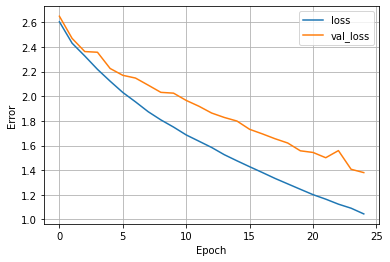

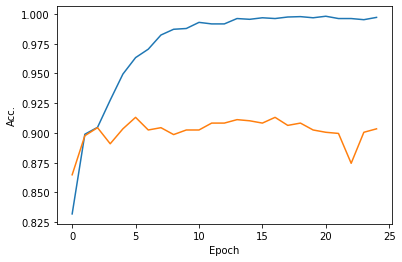

<Figure size 432x288 with 0 Axes>

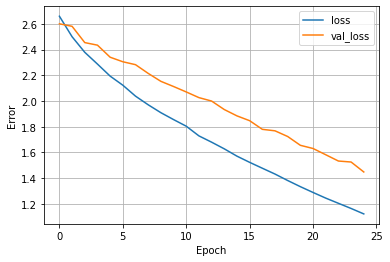

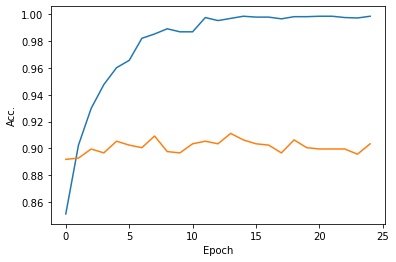

<Figure size 432x288 with 0 Axes>

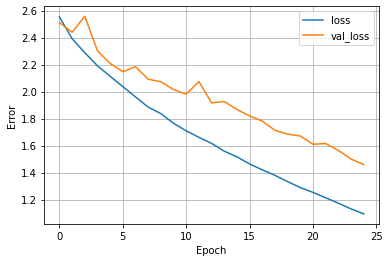

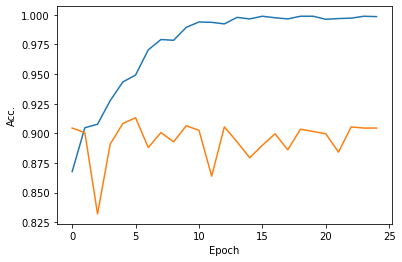

<Figure size 432x288 with 0 Axes>

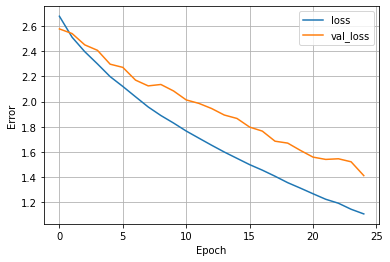

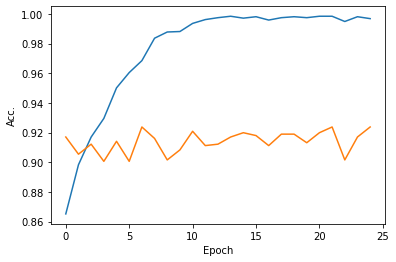

<Figure size 432x288 with 0 Axes>

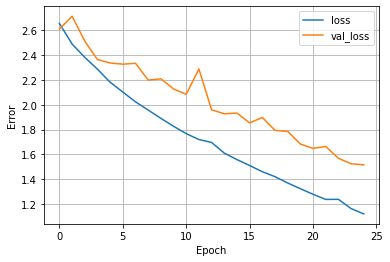

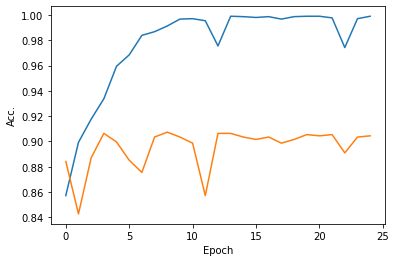

In [5]:
inputs = X
targets = y

# Define the K-fold Cross Validator
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)
# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
    cnn = build_and_compile_model()
    #Train the model
    history = cnn.fit(
    inputs[train], targets[train],                         # changed expression for test features and labels
    validation_split=0.25,                                 # I removed validation for k-fold cross validation
    verbose=1, epochs=25, 
    class_weight = class_weights)
    newfig = plt.figure()
    plot_loss(history)
    #Prediction of the validation dataset 
    test_predictions = cnn.predict(inputs[test]).flatten()
    fold_no = fold_no + 1